In [119]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ, opflow
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit.result import Result
from qiskit.providers.aer.noise import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from scipy.optimize import minimize
from qiskit.opflow import Gradient
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-15 15:23:03,798: Credentials are already in use. The existing account in the session will be replaced.


In [120]:
theta = Parameter('θ')
n=7 #number of qubits
qreg_q = QuantumRegister(n, 'q')
def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]

##Circuit Components

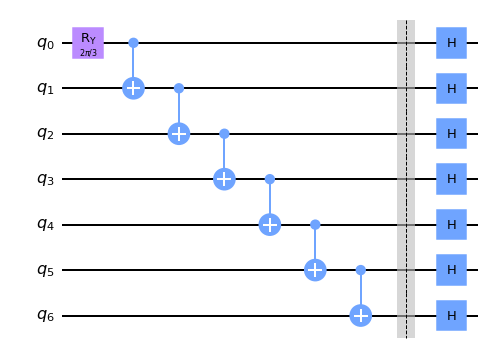

In [121]:
U_prep = QuantumCircuit(qreg_q)
U_prep.ry(2 * np.pi / 3, qreg_q[0])
for i in range(0,n-1):
    U_prep.cx(qreg_q[i], qreg_q[i+1])
U_prep.barrier()
for i in range(0,n):
    U_prep.h(qreg_q[i])
U_prep.draw()

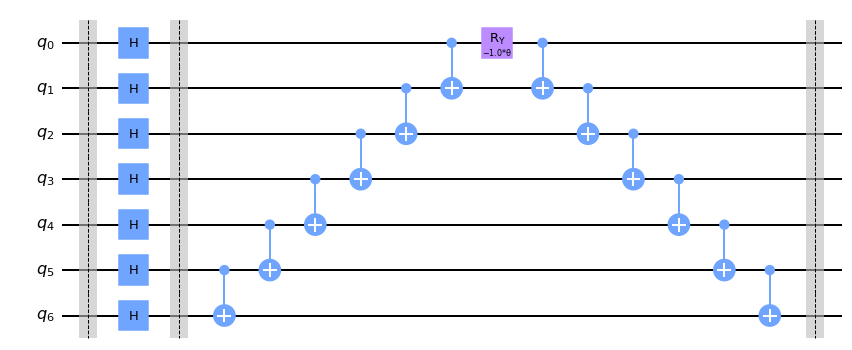

In [122]:
B_dag = QuantumCircuit(qreg_q)
B_dag.barrier()
for i in range(0,n):
    B_dag.h(qreg_q[i])
B_dag.barrier()
for i in range(n,1,-1):
    B_dag.cx(qreg_q[i-2], qreg_q[i-1])
B_dag.ry(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag.cx(qreg_q[i], qreg_q[i+1])
B_dag.barrier()
B_dag.draw()

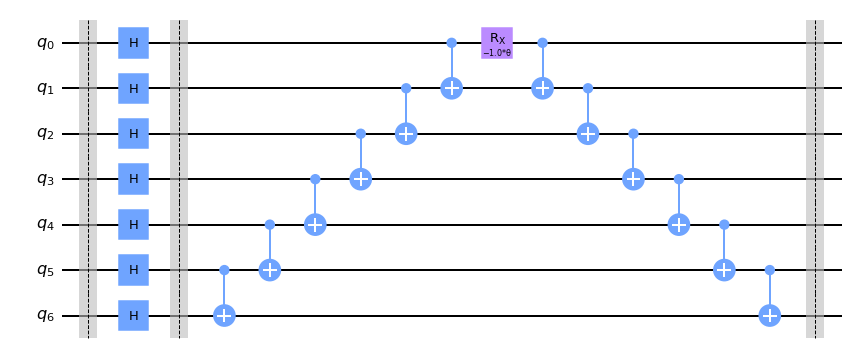

In [123]:
B_dag_rx = QuantumCircuit(qreg_q)
B_dag_rx.barrier()
for i in range(0,n):
    B_dag_rx.h(qreg_q[i])
B_dag_rx.barrier()
for i in range(n,1,-1):
    B_dag_rx.cx(qreg_q[i-2], qreg_q[i-1])
B_dag_rx.rx(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag_rx.cx(qreg_q[i], qreg_q[i+1])
B_dag_rx.barrier()
B_dag_rx.draw()

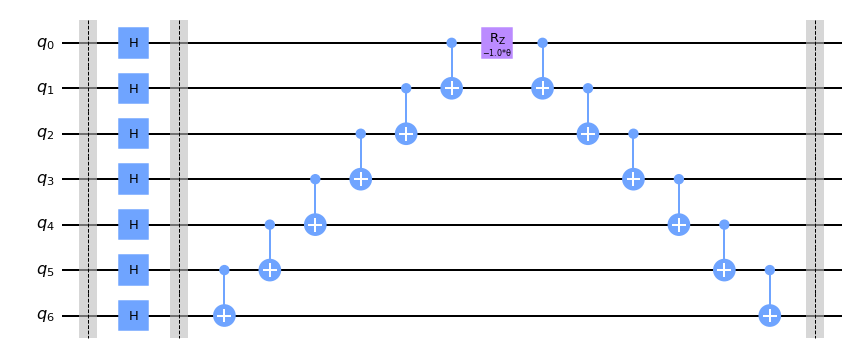

In [124]:
B_dag_rz = QuantumCircuit(qreg_q)
B_dag_rz.barrier()
for i in range(0,n):
    B_dag_rz.h(qreg_q[i])
B_dag_rz.barrier()
for i in range(n,1,-1):
    B_dag_rz.cx(qreg_q[i-2], qreg_q[i-1])
B_dag_rz.rz(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag_rz.cx(qreg_q[i], qreg_q[i+1])
B_dag_rz.barrier()
B_dag_rz.draw()

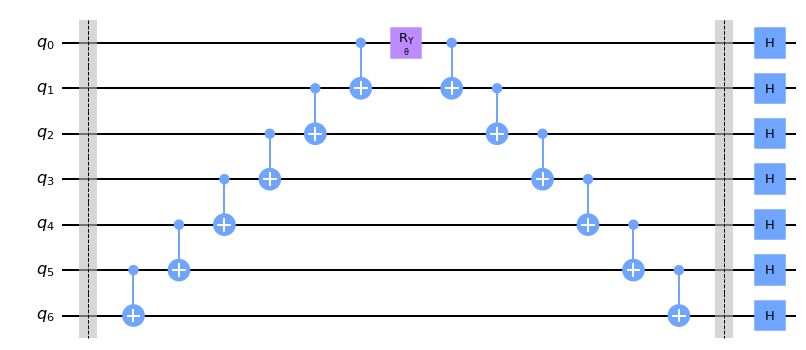

In [125]:
B = QuantumCircuit(qreg_q)
B.barrier()
for i in range(n,1,-1):
    B.cx(qreg_q[i-2], qreg_q[i-1])
B.ry(theta, qreg_q[0])
for i in range(0,n-1):
    B.cx(qreg_q[i], qreg_q[i+1])
B.barrier()
for i in range(0,n):
    B.h(qreg_q[i])
B.draw()

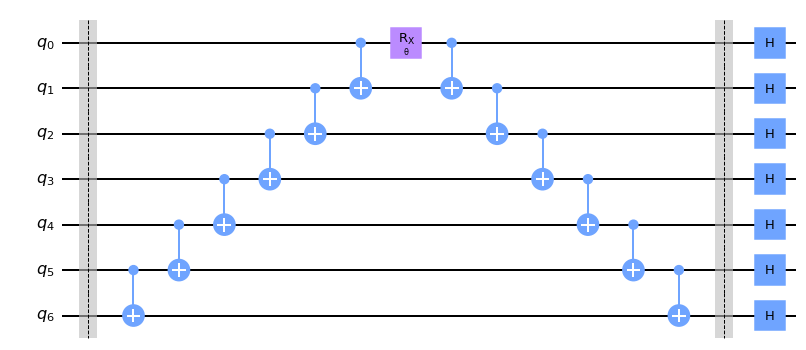

In [126]:
B_rx = QuantumCircuit(qreg_q)
B_rx.barrier()
for i in range(n,1,-1):
    B_rx.cx(qreg_q[i-2], qreg_q[i-1])
B_rx.rx(theta, qreg_q[0])
for i in range(0,n-1):
    B_rx.cx(qreg_q[i], qreg_q[i+1])
B_rx.barrier()
for i in range(0,n):
    B_rx.h(qreg_q[i])
B_rx.draw()

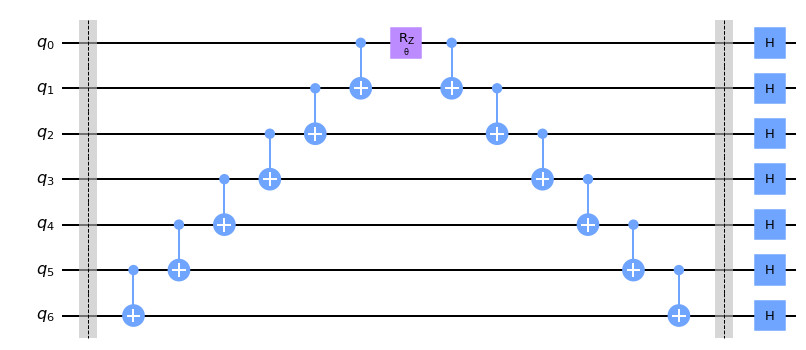

In [127]:
B_rz = QuantumCircuit(qreg_q)
B_rz.barrier()
for i in range(n,1,-1):
    B_rz.cx(qreg_q[i-2], qreg_q[i-1])
B_rz.rz(theta, qreg_q[0])
for i in range(0,n-1):
    B_rz.cx(qreg_q[i], qreg_q[i+1])
B_rz.barrier()
for i in range(0,n):
    B_rz.h(qreg_q[i])
B_rz.draw()

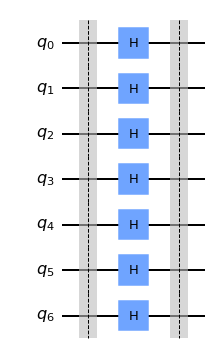

In [128]:
D = QuantumCircuit(qreg_q)
D.barrier()
for i in range(0,n):
    D.h(qreg_q[i])
D.barrier()
D.draw()

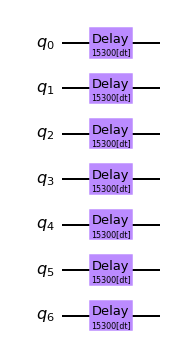

In [129]:
delay = 15300
Delay = QuantumCircuit(qreg_q)
Delay.delay(delay,unit='dt')
Delay.draw()

##Preparing psi_in

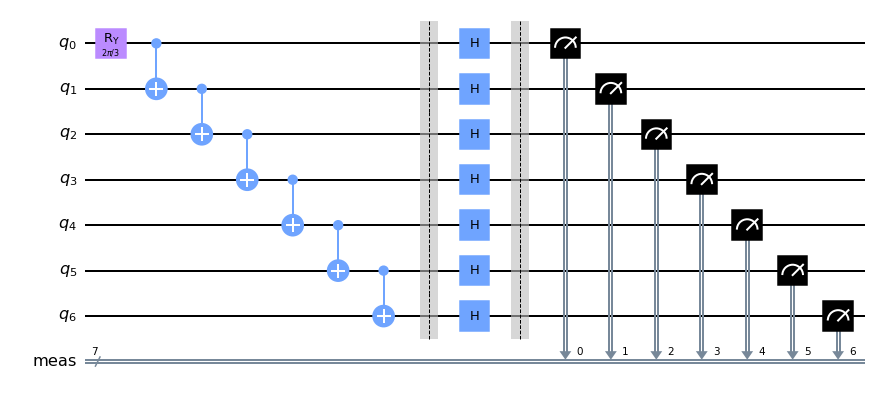

In [130]:
circuit1=U_prep.copy('circuit1')
circuit1.measure_all()
circuit1.draw()

In [131]:
backend = Aer.get_backend('aer_simulator')
counts = backend.run(circuit1, shots=1024).result().get_counts()

##Fidelity without using Collective-Collective Scheme

/tmp/ipykernel_889/2993437126.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit2=U_prep+Delay


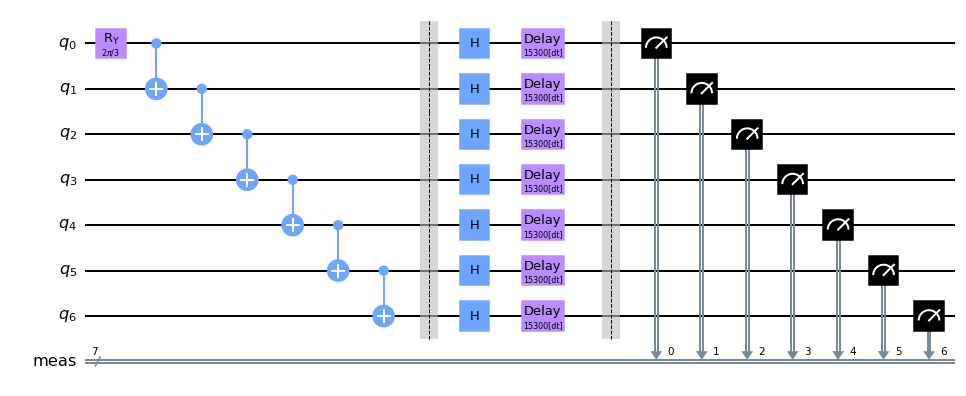

In [132]:
circuit2=U_prep+Delay
circuit2.measure_all()
circuit2.draw()

[]

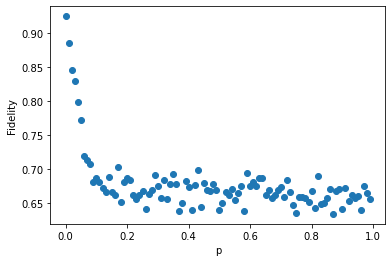

In [133]:
def p_err_vs_fidelity(p_err):
    noise_model1 = NoiseModel()
    error_1q = depolarizing_error(p_err,1)
    error_2q = error_1q.tensor(error_1q)
    noise_model1.add_all_qubit_quantum_error(error_1q, ['h', 'ry', 'delay'])
    noise_model1.add_all_qubit_quantum_error(error_2q, ['cx'])
    backend = AerSimulator(noise_model=noise_model1)
    counts1 = backend.run(circuit2,shots=1024).result().get_counts()
    sum=0.0
    for x in binseq(n):
        temp=counts[x]/1024 if (x in counts.keys()) else 0
        temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
        sum=sum+math.sqrt(temp)
    return (sum*sum)

p_err=0
p_vs_fid = dict()
while p_err<1:
    p_vs_fid.update({p_err : p_err_vs_fidelity(p_err)})
    p_err=p_err+0.01
plt.scatter(list(p_vs_fid.keys()),list(p_vs_fid.values()))
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{Y}(\theta)] $$

/tmp/ipykernel_889/3894069812.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+B_dag+Delay+B


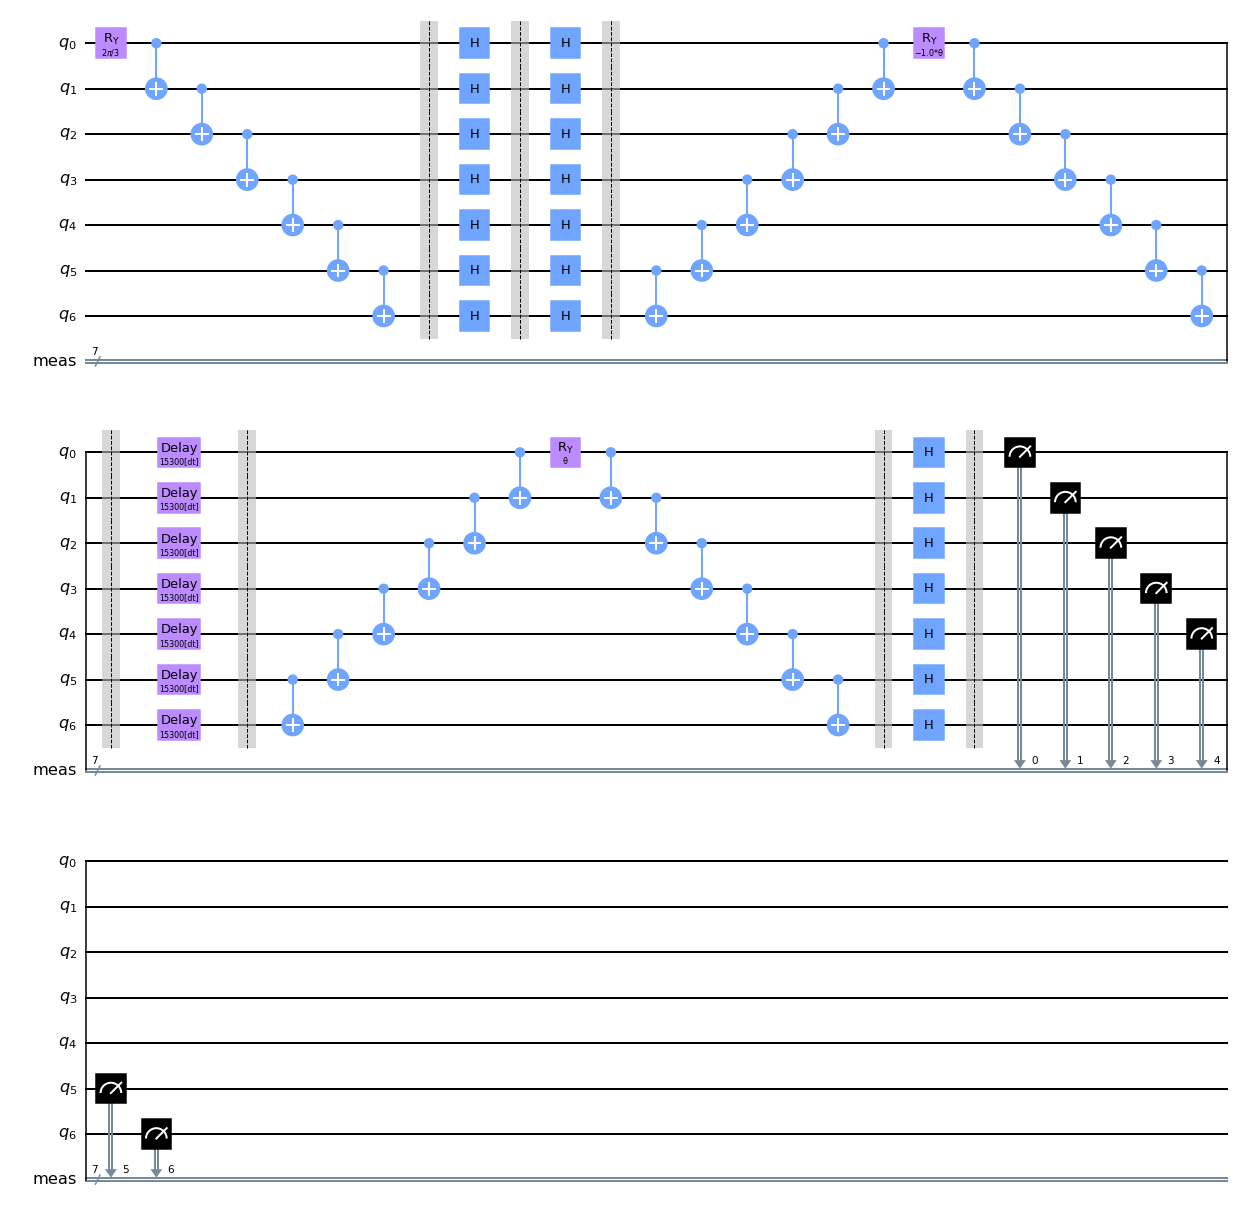

In [134]:
circuit20=U_prep+B_dag+Delay+B
circuit20.measure_all()
circuit20.draw()

[]

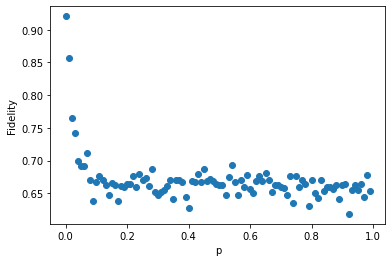

In [135]:
def p_err_vs_fidelity(p_err):
    noise_model1 = NoiseModel()
    error_1q = depolarizing_error(p_err,1)
    error_2q = error_1q.tensor(error_1q)
    noise_model1.add_all_qubit_quantum_error(error_1q, ['h', 'ry', 'delay'])
    noise_model1.add_all_qubit_quantum_error(error_2q, ['cx'])
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model1)
        counts1 = backend.run(circuit20.assign_parameters({theta : theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']

p_err=0
p_vs_fid = dict()
while p_err<1:
    p_vs_fid.update({p_err : p_err_vs_fidelity(p_err)})
    p_err=p_err+0.01
plt.scatter(list(p_vs_fid.keys()),list(p_vs_fid.values()))
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{X}(\theta)] $$

/tmp/ipykernel_889/3715287675.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+B_dag_rx+Delay+B_rx


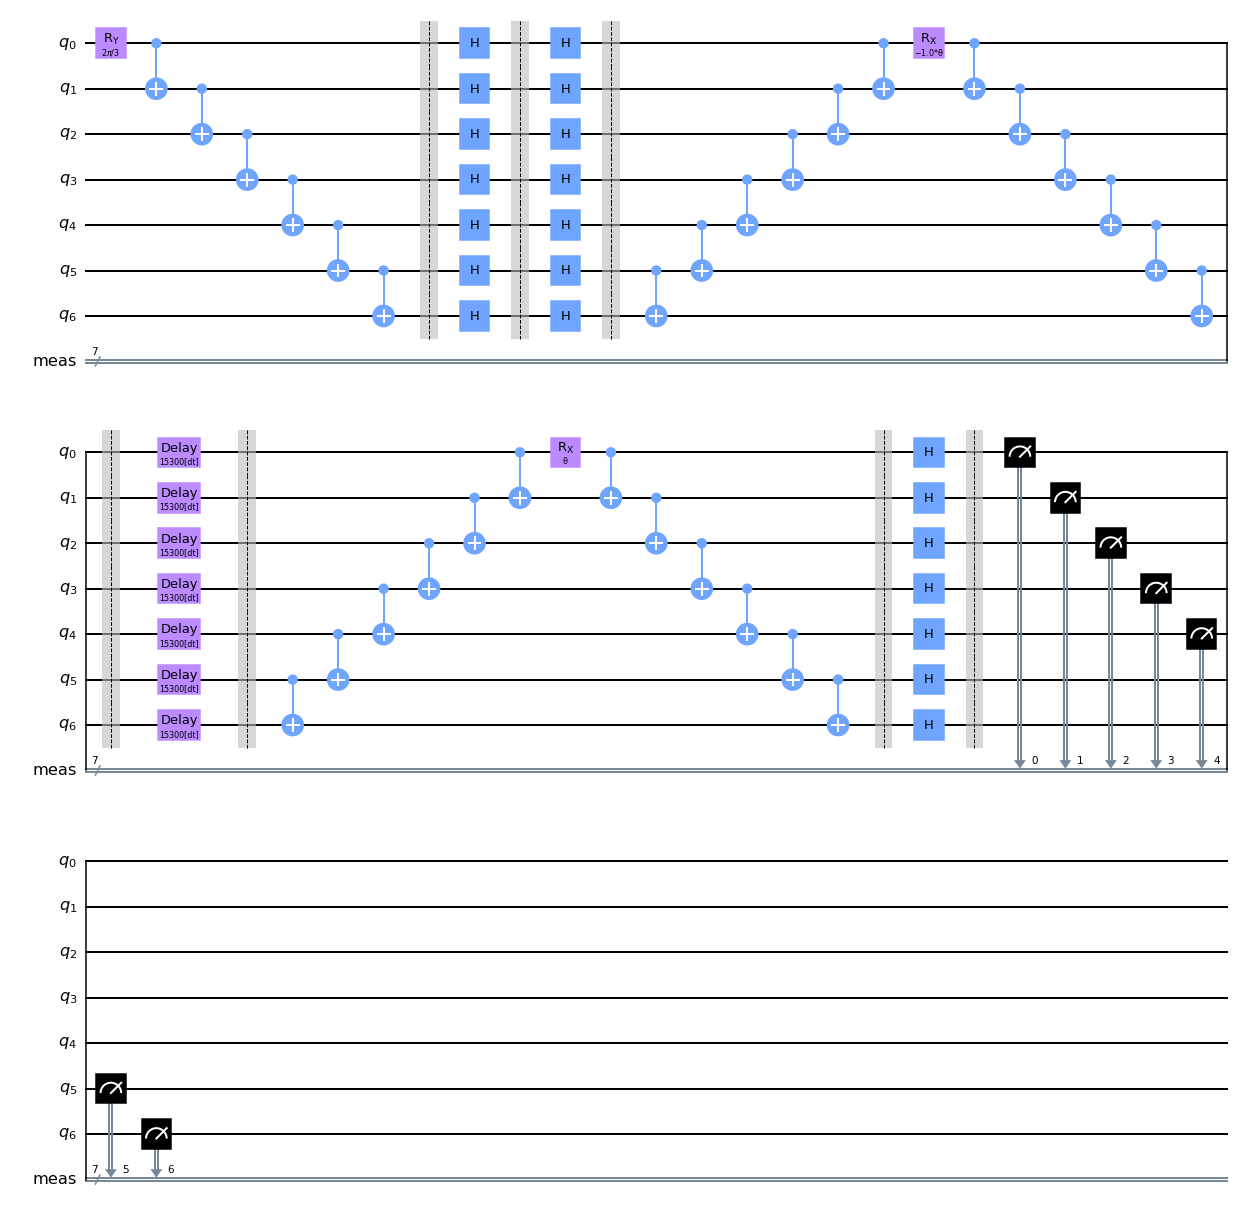

In [136]:
circuit20=U_prep+B_dag_rx+Delay+B_rx
circuit20.measure_all()
circuit20.draw()

[]

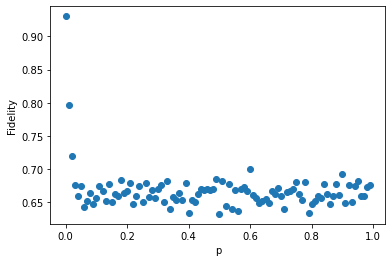

In [137]:
def p_err_vs_fidelity(p_err):
    noise_model1 = NoiseModel()
    error_1q = depolarizing_error(p_err,1)
    error_2q = error_1q.tensor(error_1q)
    noise_model1.add_all_qubit_quantum_error(error_1q, ['h', 'ry', 'rx', 'delay'])
    noise_model1.add_all_qubit_quantum_error(error_2q, ['cx'])
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model1)
        counts1 = backend.run(circuit20.assign_parameters({theta : theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']

p_err=0
p_vs_fid = dict()
while p_err<1:
    p_vs_fid.update({p_err : p_err_vs_fidelity(p_err)})
    p_err=p_err+0.01
plt.scatter(list(p_vs_fid.keys()),list(p_vs_fid.values()))
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{Z}(\theta)] $$

/tmp/ipykernel_889/242349120.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+B_dag_rz+Delay+B_rz


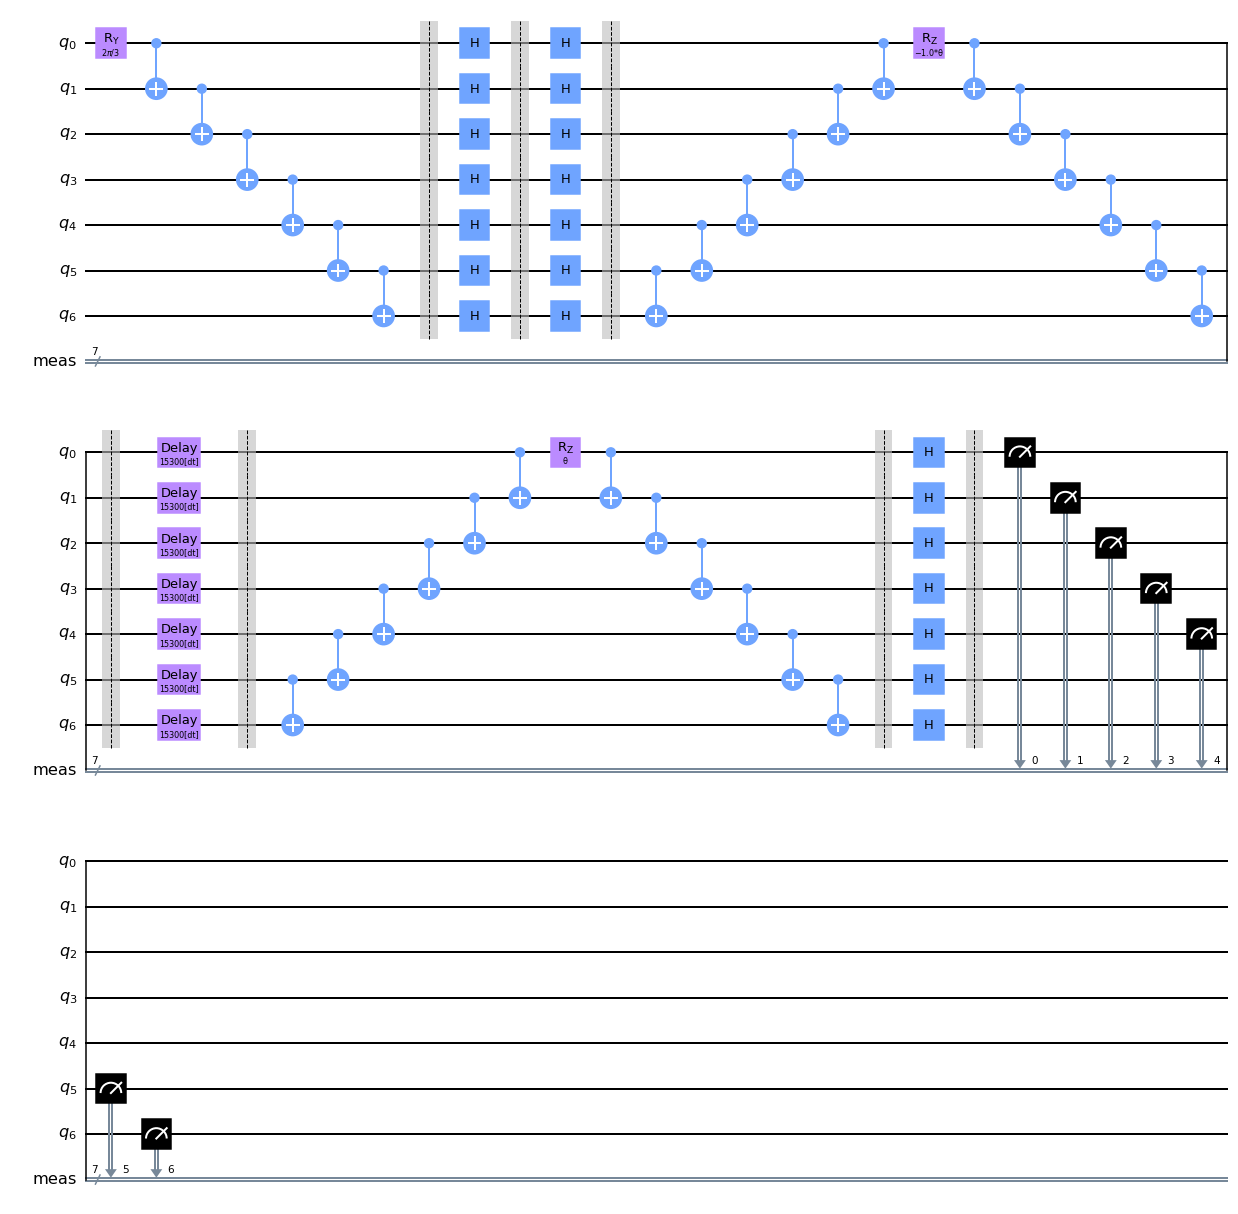

In [138]:
circuit20=U_prep+B_dag_rz+Delay+B_rz
circuit20.measure_all()
circuit20.draw()

[]

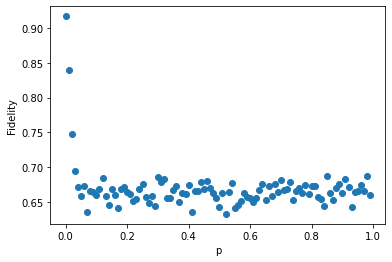

In [139]:
def p_err_vs_fidelity(p_err):
    noise_model1 = NoiseModel()
    error_1q = depolarizing_error(p_err,1)
    error_2q = error_1q.tensor(error_1q)
    noise_model1.add_all_qubit_quantum_error(error_1q, ['h', 'ry', 'rz', 'delay'])
    noise_model1.add_all_qubit_quantum_error(error_2q, ['cx'])
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model1)
        counts1 = backend.run(circuit20.assign_parameters({theta : theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']

p_err=0
p_vs_fid = dict()
while p_err<1:
    p_vs_fid.update({p_err : p_err_vs_fidelity(p_err)})
    p_err=p_err+0.01
plt.scatter(list(p_vs_fid.keys()),list(p_vs_fid.values()))
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.plot()